In [1]:
import numpy as np
import os
import sys
from astropy.table import QTable, Table, Column
from matplotlib import pyplot as plt
from lsst.daf.butler import Butler
import argparse
import sys
sys.path.append("..")
import tools
import evals

In [79]:
def generate_catalog(repo, input_coll, n_inject, trail_length, mag, beta, where="", verbose=True):
    """
    Create a catalog of trails to be injected in the input collection for the source injection. The catalog is saved in the
    astropy table format. The catalog is created by randomly selecting a position in the input collection and then
    randomly selecting the trail length, magnitude and angle of the trail. The catalog will have a visit id for each trail
    that is the same as the visit id of the calexp that the trail is injected into.

    :param repo:
    :param input_coll:
    :param n_inject:
    :param trail_length:
    :param mag:
    :param beta:
    :param where:
    :param verbose:
    :return:
    """
    butler = Butler(repo)
    registry = butler.registry
    ra = []
    dec = []
    last_id = 0
    injection_catalog = Table(
        names=('injection_id', 'ra', 'dec', 'source_type', 'trail_length', 'mag', 'beta', 'visit', 'integrated_mag'),
        dtype=('int64', 'float64', 'float64', 'str', 'float64', 'float64', 'float64', 'int64', 'float64'))
    injection_catalog.add_index('injection_id')
    source_type = "calexp"
    if where == "":
        query = registry.queryDatasets(source_type, collections=input_coll, instrument='HSC')
    else:
        query = registry.queryDatasets(source_type, collections=input_coll, instrument='HSC', where=where)
    length = len(list(query))
    for i, ref in enumerate(query):
        raw = butler.get(
            source_type,
            dataId=ref.dataId,
            collections=input_coll,
        )
        start = raw.wcs.pixelToSky(0, 0)
        end = raw.wcs.pixelToSky(raw.getDimensions()[0], raw.getDimensions()[1])
        min_ra = start.getRa()
        min_dec = start.getDec()
        max_ra = end.getRa()
        max_dec = end.getDec()
        diff_ra = max_ra - min_ra
        diff_dec = max_dec - min_dec
        min_ra = min_ra + 0.02 * diff_ra
        max_ra = max_ra - 0.02 * diff_ra
        min_dec = min_dec + 0.02 * diff_dec
        max_dec = max_dec - 0.02 * diff_dec
        if not ([min_ra, max_ra] in ra) and not ([min_dec, max_dec] in dec):
            ra.append([min_ra, max_ra])
            dec.append([min_dec, max_dec])
            for k in range(last_id, last_id + n_inject):
                ra_pos = np.random.uniform(low=min_ra.asDegrees(), high=max_ra.asDegrees())
                dec_pos = np.random.uniform(low=min_dec.asDegrees(), high=max_dec.asDegrees())
                inject_length = trail_length[k]#np.random.uniform(low=trail_length[0], high=trail_length[1])
                magnitude = mag #np.random.uniform(low=mag[0], high=mag[1])
                angle = beta #np.random.uniform(low=beta[0], high=beta[1])
                surface_brightness = magnitude + 2.5 * np.log10(inject_length)
                visitid = raw.getInfo().getVisitInfo().id
                injection_catalog.add_row([k, ra_pos, dec_pos, "Trail", inject_length, surface_brightness, angle, visitid, magnitude])
            last_id = k
        if verbose:
            print("\r", i + 1, "/", length, end="")
    if verbose:
        print("")
    return injection_catalog


def write_catalog(catalog, repo, output_coll):
    """
    Write the catalog to the output collection in the repo.

    :param catalog:
    :param repo:
    :param output_coll:
    :return:
    """
    from lsst.daf.butler import Butler
    from lsst.source.injection import ingest_injection_catalog
    writeable_butler = Butler(repo, writeable=True)
    for bands in ["g", "r", "i", "z", "y"]:
        _ = ingest_injection_catalog(
            writeable_butler=writeable_butler,
            table=catalog,
            band=bands,
            output_collection=output_coll)
    return None


def main(args):
    """
    Main function that generates the catalog of trails to be injected in the input collection and writes it to the output
    collection.

    :param args:
    :return:
    """
    #where = "instrument='HSC' AND skymap='hsc_rings_v1' AND visit=29336 AND detector=58 AND patch=50"
    #print (args.filter)
    catalog = generate_catalog(args.repo, args.input_collection, args.number, args.trail_length, args.magnitude,
                               args.beta, args.filter, args.verbose)
    print (catalog)
    write_catalog(catalog, args.repo, args.output_collection)
    return catalog


def parse_arguments(args):
    """Parse command line arguments.
    Args:
        args (list): Command line arguments.
    Returns:
        args (Namespace): Parsed command line arguments.
    """
    parser = argparse.ArgumentParser()
    parser.add_argument('-r', '--repo', type=str,
                        default='/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/',
                        help='Path to Butler repo.')
    parser.add_argument('-i', '--input_collection', type=str,
                        default="u/kmrakovc/RC2_subset/run_1",
                        help='Name of the input collection.')
    parser.add_argument('-o', '--output_collection', type=str,
                        default="u/kmrakovc/injection_inputs_tests_03",
                        help='Name of the output collection.')
    parser.add_argument('-n', '--number', type=int,
                        default=2,
                        help='Number of injections per visit.')
    parser.add_argument('-l', '--trail_length', nargs=2, type=int,
                        default=[10, 1000],
                        help='Lower and upper limit for the injected trails length.')
    parser.add_argument('-m', '--magnitude', type=float,
                        default=21,
                        help='Lower and upper limit for the injected trails magnitude.')
    parser.add_argument('-b', '--beta', type=float,
                        default=0.0,
                        help='Lower and upper limit for the injected trails rotation angle.')
    parser.add_argument('--filter', type=str,
                        default="instrument='HSC' AND skymap='hsc_rings_v1' AND visit=29336 AND detector=58 AND patch=50",
                        help='Filter the collection.')
    parser.add_argument('-v', '--verbose', action=argparse.BooleanOptionalAction,
                        default=False,
                        help='Verbose output.')
    return parser.parse_args(args)

In [80]:
catalog = main(parse_arguments(sys.argv[3:]))

injection_id         ra                dec        ... beta visit integrated_mag
------------ ------------------ ----------------- ... ---- ----- --------------
           0 149.86648939753766 2.395545993108383 ...  0.0 29336           21.0
           1 149.86391800724888 2.393956685518587 ...  0.0 29336           21.0


In [81]:
print (catalog.to_pandas().to_string())

                      ra       dec source_type  trail_length   mag  beta  visit  integrated_mag
injection_id                                                                                   
0             149.866489  2.395546       Trail          10.0  23.5   0.0  29336            21.0
1             149.863918  2.393957       Trail        1000.0  28.5   0.0  29336            21.0


In [83]:
butler = Butler('/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/')
col_name = "u/kmrakovc/single_frame_injection_test_03"
calexp_ids = list(butler.registry.queryDatasets("injected_calexp", collections=col_name, instrument='HSC'))
calexp = butler.get("injected_calexp", dataId=calexp_ids[0].dataId, collections=col_name)
injection_catalog_ids = list(butler.registry.queryDatasets("injected_postISRCCD_catalog", collections=col_name, instrument='HSC'))
injection_catalog = butler.get("injected_postISRCCD_catalog", dataId=injection_catalog_ids[0].dataId, collections=col_name)
injected_origin = calexp.wcs.skyToPixelArray(np.array([injection_catalog["ra"]]), np.array([injection_catalog["dec"]]), degrees=True)
angle = injection_catalog["beta"]
length = injection_catalog["trail_length"]
mask = np.zeros(calexp.image.array.shape)
asteroid = np.empty((2,calexp.image.array.shape[0], calexp.image.array.shape[1]))
for j in range(len(angle)):
    asteroid[j] = tools.data.draw_one_line(np.zeros(calexp.image.array.shape), (injected_origin[0][j], injected_origin[1][j]), angle[j], length[j])
    mask = tools.data.draw_one_line(mask, (injected_origin[0][j], injected_origin[1][j]), angle[j], length[j])

In [84]:
injection_catalog

injection_id,injection_flag,injection_draw_size,ra,dec,source_type,trail_length,mag,beta,visit,integrated_mag
int64,int64,int64,float64,float64,str5,float64,float64,float64,int64,float64
0,0,34,149.86648939753766,2.395545993108383,Trail,10.0,23.5,0.0,29336,21.0
1,0,2006,149.86391800724888,2.393956685518587,Trail,1000.0,28.5,0.0,29336,21.0


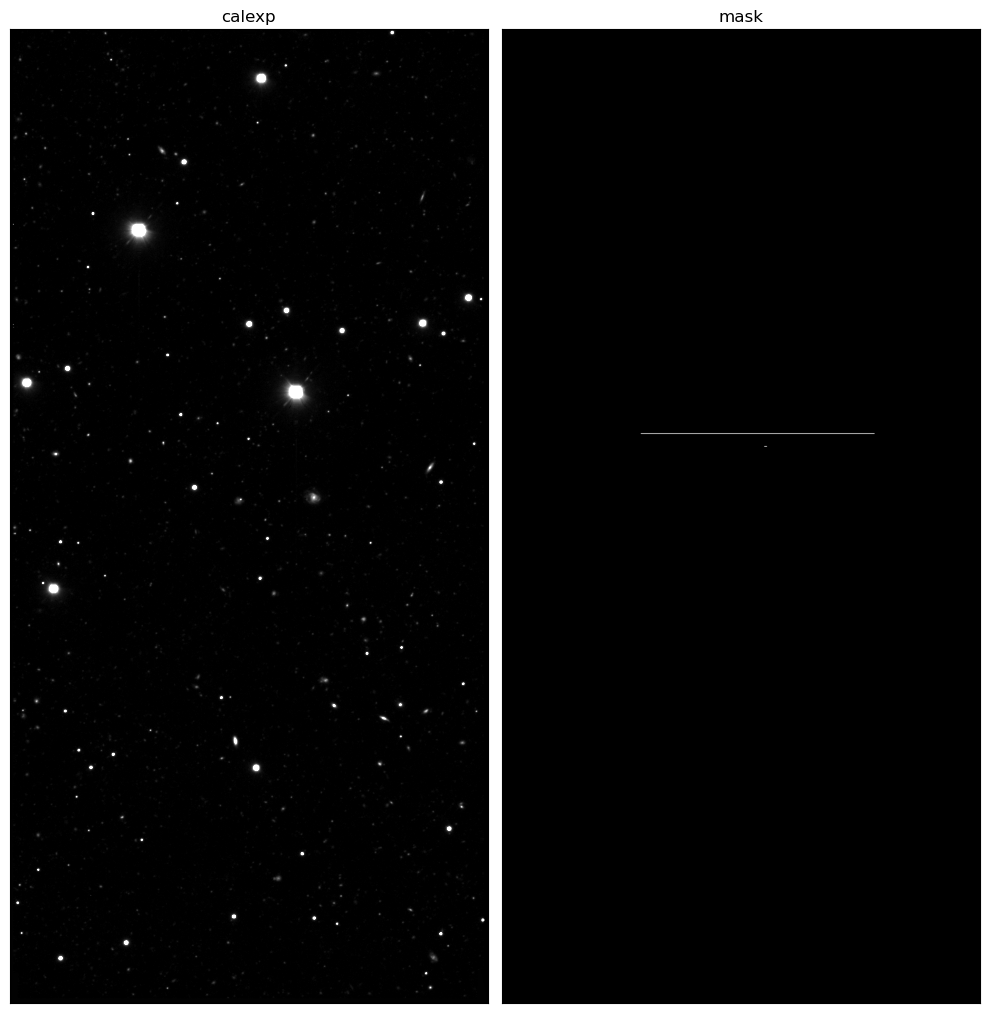

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(10,35))
ax[0].imshow(calexp.image.array, cmap="grey", vmin=0, vmax=600)
ax[1].imshow(mask, cmap="grey")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_title("calexp")
ax[1].set_title("mask")
fig.tight_layout()

In [88]:
calexp.image.array[asteroid[0]>0].flatten().mean(), calexp.image.array[asteroid[1]>0].flatten().mean()

(27.745167, 0.8911844)

Text(0.5, 1.0, 'Long Asteroid')

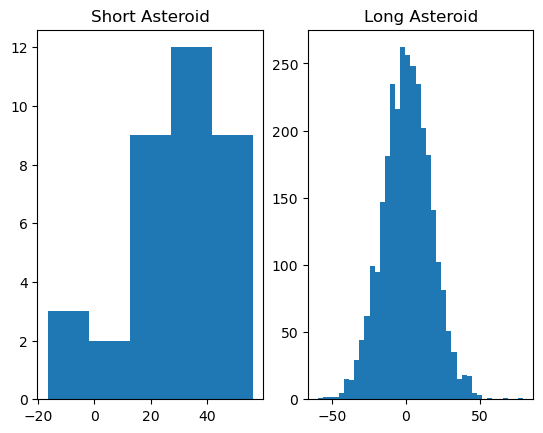

In [90]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(calexp.image.array[asteroid[0]>0].flatten(), bins=5)
ax[0].set_title("Short Asteroid")
ax[1].hist(calexp.image.array[asteroid[1]>0].flatten(), bins=40)
ax[1].set_title("Long Asteroid")

In [17]:
calib_ids = list(butler.registry.queryDatasets("calexp", collections=col_name, instrument='HSC'))

In [20]:
dir(calexp.getPhotoCalib())

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_isConstant',
 'calibrateCatalog',
 'calibrateImage',
 'computeScaledCalibration',
 'computeScalingTo',
 'getCalibrationErr',
 'getCalibrationMean',
 'getInstFluxAtZeroMagnitude',
 'getLocalCalibration',
 'getLocalCalibrationArray',
 'instFluxToMagnitude',
 'instFluxToMagnitudeArray',
 'instFluxToNanojansky',
 'isPersistable',
 'magnitudeToInstFlux',
 'magnitudeToInstFluxArray',
 'readFits',
 'writeFits']

In [82]:
print (calexp.getPhotoCalib().instFluxToMagnitude(81513.7678690941))
print (calexp.getPhotoCalib().instFluxToMagnitude(81516.54176068094))

21.005461495423443
21.00542454874119


In [73]:
print (calexp.getPhotoCalib().instFluxToMagnitude(81441.5531358384, 
                                                  lsst.geom.Point2D(injection_catalog["dec"][0], 
                                                                   injection_catalog["ra"][0])))
print (calexp.getPhotoCalib().instFluxToMagnitude(81029.8679262767, lsst.geom.Point2D(x[1], y[1])))

21.00642379791301
21.011926088601403


Point2D(241.53194031597809, 1705.5543626349595)

In [23]:
calexp.getPhotoCalib().instFluxToMagnitude(81029.8679262767)

21.011926088601403

In [25]:
dir(calexp.wcs)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'copyAtShiftedPixelOrigin',
 'getCdMatrix',
 'getFitsMetadata',
 'getFrameDict',
 'getPixelOrigin',
 'getPixelScale',
 'getRelativeRotationToWcs',
 'getSkyOrigin',
 'getTanWcs',
 'getTransform',
 'isFits',
 'isFlipped',
 'isPersistable',
 'linearizePixelToSky',
 'linearizeSkyToPixel',
 'pixelToSky',
 'pixelToSkyArray',
 'readFits',
 'readString',
 'skyToPixel',
 'skyToPixelArray',
 'writeFits',
 'writeString']

In [35]:
type(calexp.wcs.linearizePixelToSky(calexp.wcs, calexp.wcs.pixelToSky(0,0)))

TypeError: linearizePixelToSky(): incompatible function arguments. The following argument types are supported:
    1. (self: lsst.afw.geom.SkyWcs, coord: lsst.geom.SpherePoint, skyUnit: lsst.geom.AngleUnit) -> lsst.geom.AffineTransform
    2. (self: lsst.afw.geom.SkyWcs, coord: lsst.geom.Point2D, skyUnit: lsst.geom.AngleUnit) -> lsst.geom.AffineTransform

Invoked with: FITS standard SkyWcs:
Sky Origin: (149.8816613012, +2.3909031639)
Pixel Origin: (1029.11, 2113.28)
Pixel Scale: 0.168412 arcsec/pixel, FITS standard SkyWcs:
Sky Origin: (149.8816613012, +2.3909031639)
Pixel Origin: (1029.11, 2113.28)
Pixel Scale: 0.168412 arcsec/pixel, SpherePoint(149.78290633008004*degrees, 2.342522742479151*degrees)

In [33]:
type(calexp.wcs.pixelToSky(0,0))

lsst.geom.SpherePoint

In [34]:
type(calexp.wcs)

lsst.afw.geom.SkyWcs

In [54]:
y, x = calexp.wcs.skyToPixelArray(np.array([injection_catalog["ra"]]), np.array([injection_catalog["dec"]]), degrees=True)

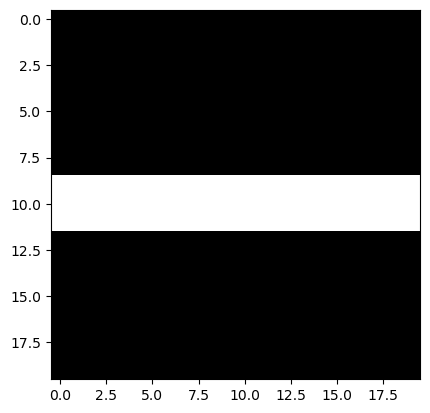

In [58]:
plt.imshow(mask[int(x[1])-10:int(x[1])+10, int(y[1])-10:int(y[1])+10]  , cmap="grey")